![Logo Detran](https://detran.es.gov.br/Media/detran/_Profiles/948274ae/8ab0c8fd/logoDETRAN.png?v=637108650540947223)

# Apresentação da tecnologia de reconhecimento facial para o Detran-ES

Esta apresentação passará pelos detalhes do código desenvolvido pela equipe da Vert Soluções em TIC, utilizando de imagens exemplo para explicar o código e o funcionamento da tecnologia

**Vert Development Team**: Thiago Luis Pinho, Lucas Moutinho, Rodrigo Ferrari 

# Atualiza Conhecidos
 -*- coding: utf-8 -*-

Código desenvolvido para converter uma database de imagens em códigos de incorporações
que depois podem ser comparados a fim de validar se um rosto pertence a pessoa registrada com o mesmo identificador.


### Realiza importações de bibliotecas auxiliares e da rede neural de códigos de incorporação

In [1]:
import keras_vggface
# Importa a rede neural já treinada que gera os códigos de incorporação.
# Caso você queira saber a versão, basta descomentar o código abaixo.
# print(keras_vggface.__version__),
import argparse
import pickle
from encoding_helpers import get_embeddings, store_codes_with_names, is_match
from image_helpers import save_image
from matplotlib import pyplot
from PIL import Image, ExifTags

Using TensorFlow backend.


### Converte as imagens da database em códigos de incorporação

In [4]:
# Converte as imagens da database em códigos de incorporação
embbedings, person_names, filenames, images = get_embeddings("database_conhecidos")

[INFO] Contando rostos em database_conhecidos ...
[INFO] Processando imagem 1/3
[INFO] Processando imagem 2/3
[INFO] Processando imagem 3/3


#### Cada imagem processada acima passa pelo processo que será exemplificado abaixo:
- O Código procura no "database_conhecidos" pelas imagens dentro da pasta e as associa à um nome (ou CPF)

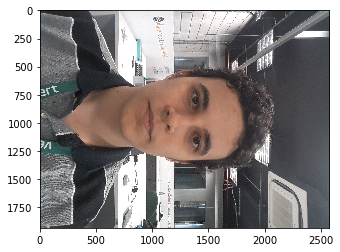

In [5]:
image = Image.open("./database_conhecidos/rodrigo/rodrigo1.jpg")
imgplot = pyplot.imshow(image)

In [ ]:
def get_embeddings( database_folder_name, crop=True ):
  ''' Recebe uma lista de nomes de arquivos para serem abertos. Caso crop = True, ele antes de calcular
  o embedding tenta encontrar o rosto e retorna uma imagem com somente ele. 
  Retorna uma lista de códigos de incorporação e uma lista dos nomes correspondentes desses códigos'''
  # Pega o caminho para a database passada no argumento
  print("[INFO] Contando rostos em " + database_folder_name + " ...")
  imagePaths = list(paths.list_images( database_folder_name ))
  faces = []
  filenames = []
  person_names = []
  images = []
  # Itera sobre os caminhos das imagens
  for (i, imagePath) in enumerate(imagePaths):
    # Extrai a face da pessoa na imagem, caso haja
    print("[INFO] Processando imagem {}/{}".format(i + 1,
      len(imagePaths)))

    filename = imagePath.split(os.path.sep)[-1]
    person_name = imagePath.split(os.path.sep)[-2]
    filenames.append(filename)
    person_names.append(person_name)
    
    if crop == True:
      # Se os rostos precisarem ser cortados das fotos, ele o faz.
      face_nparray, original_image = open_crop_and_resize_face(imagePath)
    else:
      # Caso contrário ele somente abre e muda para o tamanho adequado.
      face_nparray = pyplot.imread(imagePath)
      face_nparray = cv2.resize(face_nparray, (224,224) )

    faces.append(face_nparray)
    images.append(original_image)

    #  Converte em um array de samples
  samples = asarray(faces, 'float32')
  # Faz os preprocessamentos necessários nas imagens para elas entrarem no modelo. Ex: Centraliza o rosto
  samples = preprocess_input(samples, version=2)
  # Cria um modelo já treinado do VGGFace
  model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
  # Aplica o modelo sobre as imagens e retorna um vetor de códigos de incorporação
  embeddings = model.predict(samples)

  return embeddings, person_names, filenames, images

### Armazena os nomes e códigos de incorporação gerados no arquivo "encodings.pickle" que será usado como database de referência para códigos de imagens conhecidas

In [6]:
# Itera sobre os códigos de incorporações
dados_conhecidos = store_codes_with_names(embbedings, person_names, filenames, images)

# Armazena os nomes e códigos gerados
f = open("encodings.pickle", "wb")
f.write(pickle.dumps(dados_conhecidos))
f.close()

# Compara Desconhecidos
 -*- coding: utf-8 -*-

Código desenvolvido para comparar uma imagem de um rosto( o nome do arquivo deve ser o nome da pessoa)
com uma database já convertida em código de incorporação
e valida se é a mesma pessoa ou não.

## Configurando variáveis de comportamento para o código

In [ ]:
args = {"image" : "database_comparacao" # Caminho para a database de imagens a serem comparadas"
        , "encodings" : "encodings.pickle" # Caminho para uma database serializada com os códigos de incorporação das faces
        , "detection-method" : "cnn"    # Modelo de detecção facial a ser usado 'cnn' ou 'hog'
}

### Carregando códigos de Incorporação da base de dados conhecida

In [ ]:
print("[INFO] Carregando dados de pessoas conhecidas...")
dados_conhecidos = pickle.loads(open(args["encodings"], "rb").read())

unknown_encodings, unknown_names, unknown_filenames, unknown_images = get_embeddings(args["image"])

### Comparamos as pessoas com seus respectivos registros na base de dados conhecida

In [ ]:
# Organizamos as prováveis pessoas por nome com seus respectivos códigos e nome do arquivo
dados_comparacao = store_codes_with_names(unknown_encodings, unknown_names, unknown_filenames, unknown_images)

for pessoa_comparada in dados_comparacao.keys():
  # Primeiro procuramos em database pela pessoa a ser comparada
  if pessoa_comparada in dados_conhecidos:
    dados_por_pessoa = dados_conhecidos[ pessoa_comparada ]
    
    for codigo_comparado, nome_arquivo_comparado, imagem_comparada in dados_comparacao [pessoa_comparada]:
    # Depois iteramos pelas imagens a serem comparadas da mesma pessoa
      matches = []
      for codigo_conhecido, nome_arquivo_conhecido, imagem_conhecida in dados_por_pessoa:
        # Nós armazenamos os resultados em uma lista
        matches.append( is_match( codigo_comparado, codigo_conhecido ) )

      if( matches.count(True) >= len(matches)/2 ):
        # Se mais que a metade dos rostos baterem, consideramos a pessoa como a mesma
        print( "A imagem " + nome_arquivo_comparado + " é do " + pessoa_comparada )
        # Salva imagem comparada e conhecida na pasta de comparações aprovadas
        save_image(imagem_comparada, nome_arquivo_comparado, nome_arquivo_conhecido, nome_database = "aprovadas")
      else: 
        print( "A imagem " + nome_arquivo_comparado + " não é do " + pessoa_comparada )
        # Salva imagem comparada e conhecida na pasta de comparações vetadas
        save_image(imagem_comparada, nome_arquivo_comparado, nome_arquivo_conhecido, nome_database = "vetadas")


  else: 
    # Caso a pessoa não seja encontrada na base de dados conhecida, ela não é comparada 
    # e um aviso é emitido no terminal
    dados_pessoa_sem_comparacao = dados_comparacao[pessoa_comparada]
    print("A pessoa " + pessoa_comparada + " não foi encontrada na base de dados conhecida.")
    for codigo_sem_comparacao, nome_arquivo_nao_comparado, imagem_sem_comparacao in dados_pessoa_sem_comparacao:
      print("A imagem com nome " + nome_arquivo_nao_comparado + " não teve uma pessoa encontrada na database correspondente")



In [ ]:
# Compara Desconhecidos
 -*- coding: utf-8 -*-

Código desenvolvido para comparar uma imagem de um rosto( o nome do arquivo deve ser o nome da pessoa)
com uma database já convertida em código de incorporação
e valida se é a mesma pessoa ou não.
 

**Autor:** Rodrigo Ferrari 

**Editores**: Thiago Luis Pinho, Lucas Moutinho

**Last edit:** 2019/12/02


import argparse
import pickle
from encoding_helpers import get_embeddings, is_match, store_codes_with_names
from image_helpers import save_image

## Configurando variáveis de comportamento para o código

args = {"image" : "database_comparacao" # Caminho para a database de imagens a serem comparadas"
        , "encodings" : "encodings.pickle" # Caminho para uma database serializada com os códigos de incorporação das faces
        , "detection-method" : "cnn"    # Modelo de detecção facial a ser usado 'cnn' ou 'hog'
}

### Carregando códigos de Incorporação da base de dados conhecida

print("[INFO] Carregando dados de pessoas conhecidas...")
dados_conhecidos = pickle.loads(open(args["encodings"], "rb").read())

unknown_encodings, unknown_names, unknown_filenames, unknown_images = get_embeddings(args["image"])

### Comparamos as pessoas com seus respectivos registros na base de dados conhecida

# Organizamos as prováveis pessoas por nome com seus respectivos códigos e nome do arquivo
dados_comparacao = store_codes_with_names(unknown_encodings, unknown_names, unknown_filenames, unknown_images)

for pessoa_comparada in dados_comparacao.keys():
  # Primeiro procuramos em database pela pessoa a ser comparada
  if pessoa_comparada in dados_conhecidos:
    dados_por_pessoa = dados_conhecidos[ pessoa_comparada ]
    
    for codigo_comparado, nome_arquivo_comparado, imagem_comparada in dados_comparacao [pessoa_comparada]:
    # Depois iteramos pelas imagens a serem comparadas da mesma pessoa
      matches = []
      for codigo_conhecido, nome_arquivo_conhecido, imagem_conhecida in dados_por_pessoa:
        # Nós armazenamos os resultados em uma lista
        matches.append( is_match( codigo_comparado, codigo_conhecido ) )

      if( matches.count(True) >= len(matches)/2 ):
        # Se mais que a metade dos rostos baterem, consideramos a pessoa como a mesma
        print( "A imagem " + nome_arquivo_comparado + " é do " + pessoa_comparada )
        # Salva imagem comparada e conhecida na pasta de comparações aprovadas
        save_image(imagem_comparada, nome_arquivo_comparado, nome_arquivo_conhecido, nome_database = "aprovadas")
      else: 
        print( "A imagem " + nome_arquivo_comparado + " não é do " + pessoa_comparada )
        # Salva imagem comparada e conhecida na pasta de comparações vetadas
        save_image(imagem_comparada, nome_arquivo_comparado, nome_arquivo_conhecido, nome_database = "vetadas")


  else: 
    # Caso a pessoa não seja encontrada na base de dados conhecida, ela não é comparada 
    # e um aviso é emitido no terminal
    dados_pessoa_sem_comparacao = dados_comparacao[pessoa_comparada]
    print("A pessoa " + pessoa_comparada + " não foi encontrada na base de dados conhecida.")
    for codigo_sem_comparacao, nome_arquivo_nao_comparado, imagem_sem_comparacao in dados_pessoa_sem_comparacao:
      print("A imagem com nome " + nome_arquivo_nao_comparado + " não teve uma pessoa encontrada na database correspondente")

